## Load packages
Firstly, we load the necessary packages for the code to run

In [1]:
import torch

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import NMF

from random import sample

import copy
from functions import plotsigs, cosine_perm
from NMFAE_init import NMFAE, train_NMFAE

## Split data
Firstly we write a method to split the mutational profile matrix into a training and validation set.

In [2]:
def split_data(data, frac):
  x_train = data.sample(frac=frac)
  x_val = data.drop(x_train.index)
  return x_train, x_val

## Simulated data
The anaylysis will be performed on simulated data. The data is simulated using the following method:

In [3]:
def simulate_counts(nsigs, npatients):
  #Arrange COSMIC to be the same ordering as count data
  COSMIC = pd.read_csv(r'Q:\AUH-HAEM-FORSK-MutSigDLBCL222\external_data\COSMIC_SIGNATURES\COSMIC_v3.2_SBS_GRCh37.txt', sep='\t', index_col=0)
  context = COSMIC.index
  mutation = [s[2:5] for s in context]
  COSMIC['mutation'] = mutation
  COSMIC = COSMIC.sort_values('mutation')
  mutation = COSMIC['mutation']
  context = COSMIC.index
  COSMIC = COSMIC.drop('mutation', axis = 1)


  n_mutations = len(mutation)
  patients = ["Patient" + str(i) for i in range(1,(npatients+1))]

  sig_names = sample(list(COSMIC.columns), nsigs)
  sigs = COSMIC[sig_names]

  def generate_exposure(nsigs):
    zinf = np.random.binomial(n = 1, p = 0.09, size = nsigs)>0 
    not_zinf = [not z for z in zinf]
    #parametrized negative binomial with mean 600
    total_muts = np.random.negative_binomial(p =1- 300/301, n = 2, size = 1)
    distribution = np.random.dirichlet(alpha=[1]*nsigs, size= 1)

    res = (np.multiply(not_zinf, distribution)*total_muts).tolist()
    #because it somehow made a list of lists
    return(res[0])
  
  E = [generate_exposure(nsigs) for _ in range(npatients)]
  Exposures = pd.DataFrame(E).transpose()

  Exposures.columns = patients
  Exposures.index = sig_names
  
  V = pd.DataFrame(np.round(np.dot(sigs, Exposures),0))
  V.columns = patients
  V.index = context

  return((V, sigs, Exposures))

# NMF performance

In [4]:
def out_errorNMF(train_df, validation_df, nsigs ,true_sigs):
  model = NMF(n_components=nsigs, init='random', max_iter = 500)
  exposures = model.fit_transform(train_df)
  signatures = model.components_
  
  cos_NMF = cosine_perm(true_sigs.to_numpy().transpose(), signatures)[0]
  cos_mean = np.mean(cos_NMF.diagonal())


  ref_exposures = model.transform(X = validation_df)
  rec = np.dot(ref_exposures, signatures)
  MSE = np.mean(((validation_df - rec)**2).to_numpy())

  return([cos_mean, MSE])

# AAUtoSig performance

In [5]:
def out_errorAE(train_df, validation_df, nsigs, true_sigs):
  model = NMFAE(dim1 = nsigs)

  # Validation using MSE Loss function
  loss_function = torch.nn.MSELoss(reduction='mean')

  # Using an Adam Optimizer with lr = 0.1
  optimizer = torch.optim.Adam(model.parameters(),
                                lr = 1e-3)
                              
  train_NMFAE(epochs = 500, 
                model = model, 
                x_train = train_df, 
                loss_function = loss_function, 
                optimizer = optimizer)

  W = model.dec1.weight.data    
  W_array = W.numpy()

  cos_AE = cosine_perm(true_sigs.to_numpy().transpose(),W_array.transpose())[0]
  cos_mean = np.mean(cos_AE.diagonal())

  x_validation_tensor = torch.tensor(validation_df.values, 
                                      dtype = torch.float32)
  rec = model(x_validation_tensor)
  MSE = (float(loss_function(rec,x_validation_tensor).detach().numpy()))

  return([cos_mean, MSE])

## Performance analysis

In [6]:
def performance_analysis(npatients, nsigs):
  mut_matrix, signatures, _ = simulate_counts(nsigs, npatients)
  train_data, validation_data = split_data(mut_matrix.transpose(), 0.8)
  return(out_errorNMF(train_data, validation_data, nsigs, signatures) + out_errorAE(train_data, validation_data, nsigs, signatures))
asd = np.array([performance_analysis(1200, 4) for i in range(100)])
result = pd.DataFrame(asd)
result.columns = ["cosineNMF", "outNMF", "cosineAE", "outAE"]


C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\skl

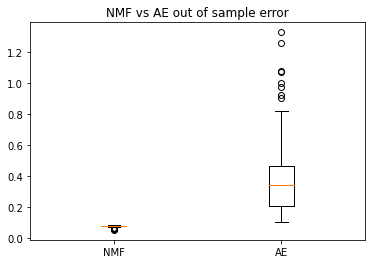

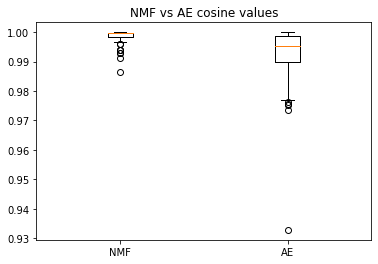

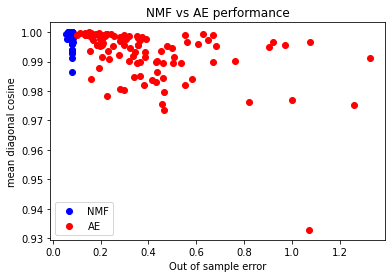

In [7]:
plt.boxplot(result[['outNMF', 'outAE']], labels = ["NMF", "AE"])
plt.title('NMF vs AE out of sample error')
plt.show()

plt.boxplot(result[['cosineNMF', 'cosineAE']],labels = ["NMF", "AE"])
plt.title('NMF vs AE cosine values')
plt.show()

plt.scatter(y = result['cosineNMF'], x = result['outNMF'], c = 'blue', label = 'NMF')
plt.scatter(y = result['cosineAE'], x = result['outAE'], c = 'red', label = 'AE')
plt.xlabel('Out of sample error')
plt.ylabel('mean diagonal cosine')
plt.title('NMF vs AE performance')
plt.legend()
plt.show()